In [30]:
import pandas as pd              # pandas.pydata.org
import geopandas as gpd          # geopandas.org
import matplotlib.pyplot as plt  # matplotlib.org
import numpy as np               # numpy.org
import json                      # docs.python.org/3/library/json.html
from pathlib import Path         # docs.python.org/3/library/pathlib.html
import time                      # docs.python.org/3/library/time.html

# pypi.org/project/Shapely
# Manipulation and analysis of geometric objects in the Cartesian plane
#    conda install -c conda-forge shapely
import shapely.geometry as sg

In [28]:
# Set the environment
DirData     = Path('data')
RoadGeod    = Path('sao-paulo_brazil_roads_gen1.geojson')
CrashData   = Path('BaseCompletaNov17.csv')
ReduData    = Path('BaseRedu.csv')

# World Geodetic System coordinate system.
WGS84 = {'init': 'epsg:4326'}

# Web Mercator (WGS84/Pseudo-Mercator) coordinate system.
# Used by major online map providers, including Google Maps,
#   Mapbox, Bing Maps, OpenStreetMap, Mapquest, Esri, and others.
# <https://en.wikipedia.org/wiki/Web_Mercator_projection>
WM = {'init': 'epsg:3857'}

In [24]:
# Filter crash data and save to (smaller) file
path = DirData/CrashData
f = pd.read_csv(path,
                sep=';',
                decimal=',',
                encoding='ISO-8859-15',
                low_memory=False,
                error_bad_lines=False
               )

# Rename columns
f = f.rename(columns={
    'Cidade Considerada':'CIDADE',
    'Região Administrativa':'REG_ADM',
    'Ano Óbito':'ANO',
    'Mês Óbito':'MES',
    'Mês Descrição':'DESC_MES',
    'Sexo':'SEXO',
    'Turno':'TURNO',
    'Tipo Acidente':'TIPO',
    'Tipo Veiculo': 'VEIC',
    'Faixa Etária':'FAIX_ETAR',
    'Idade':'IDADE',
    'Hora Acidente':'HORA',
    'Tipo Vítima':'VITIMA',
    'Tipo Local do Acidente':'LOCAL',
    'Dia Semana':'DIA_SEM',
    'Tipo de Via':"VIA",
    'LAT_(geo)':'LAT',
    'LONG_(geo)':'LONG',
    'Rua / Rodovia':'NOME'
    })

# Rearrange columns, if need
#cols = [
#    'NOME',
#    'CIDADE',
#    'REG_ADM',
#    'ANO',
#    'MES',
#    'DESC_MES',
#    'SEXO',
#    'TURNO',
#    'TIPO',
#    'VEIC',
#    'FAIX_ETAR',
#    'IDADE',
#    'HORA',
#    'VITIMA',
#    'LOCAL',
#    'DIA_SEM',
#    'VIA',
#    'LAT',
#    'LONG',
#    ]
#f = f[cols]

# Reformat column - str to float  (WGS84)
f['LAT'] = ( f['LAT'].str.replace(',','.')
                     .apply(pd.to_numeric, errors='coerce')
           )
f['LONG'] = ( f['LONG'].str.replace(',','.')
                       .apply(pd.to_numeric, errors='coerce')
            )

# Delete NaN lines
f = f[ ~np.isnan(f['LAT']) ].copy()

# Display
f.head()

,CIDADE,REG_ADM,ANO,MES,DESC_MES,SEXO,TURNO,TIPO,VEIC,FAIX_ETAR,IDADE,HORA,VITIMA,LOCAL,DIA_SEM,VIA,LAT,LONG,NOME
0,SAO PAULO,Metropolitana de São Paulo,2017,10,OUTUBRO,MASCULINO,TARDE,ATROPELAMENTO,PEDESTRE,65-69,66,NaN,PEDESTRE,PUBLICO,QUARTA,Vias Municipais,-23.466729,-46.583952,AVENIDA GUAPIRA
9421,HORTOLANDIA,Campinas,2016,8,AGOSTO,MASCULINO,TARDE,NAO DISPONIVEL,NAO DISPONIVEL,18-24,24,NaN,NAO DISPONIVEL,NAO DISPONIVEL,SEGUNDA,Rodovias,-22.904026,-47.205117,SP 101
9422,POMPEIA,Marília,2016,8,AGOSTO,FEMININO,NOITE,COLISAO,AUTOMOVEL,18-24,21,NaN,PASSAGEIRO,PUBLICO,SEGUNDA,Rodovias,-22.103232,-50.216331,SP 294
9423,BRAGANCA PAULISTA,Campinas,2016,8,AGOSTO,MASCULINO,NOITE,COLISAO,AUTOMOVEL,40-44,43,NaN,NAO DISPONIVEL,PUBLICO,TERÇA,Rodovias,-22.944480,-46.476241,BR 381
9424,MOGI GUACU,Campinas,2016,8,AGOSTO,MASCULINO,NOITE,ATROPELAMENTO,PEDESTRE,18-24,19,NaN,PEDESTRE,PUBLICO,DOMINGO,Rodovias,-22.146250,-46.995781,SP 340


In [25]:
# Filter crashes and drop bad locations
# drop the outside map region
cond  = (f['LAT'] < -23.1)
cond &= (f['LONG'] > -47.4)
cond &= (f['LONG'] < -45.7)

# if desired is possible to filter even more
# drop: PEDESTRE|NAO DISPONIVEL|BICICLETA|ATROPELAMENTO|OUTROS
# cond &= f['VEIC'].str.contains(
#    r'AUTO|CAMI|MOTO|ONIB'
#    )

# Filter
f2 = f[ cond ].copy()

# Display
f2.head()

,CIDADE,REG_ADM,ANO,MES,DESC_MES,SEXO,TURNO,TIPO,VEIC,FAIX_ETAR,IDADE,HORA,VITIMA,LOCAL,DIA_SEM,VIA,LAT,LONG,NOME
0,SAO PAULO,Metropolitana de São Paulo,2017,10,OUTUBRO,MASCULINO,TARDE,ATROPELAMENTO,PEDESTRE,65-69,66,NaN,PEDESTRE,PUBLICO,QUARTA,Vias Municipais,-23.466729,-46.583952,AVENIDA GUAPIRA
9426,SAO PAULO,Metropolitana de São Paulo,2016,8,AGOSTO,MASCULINO,MANHA,OUTROS,MOTOCICLETA,45-49,47,NaN,CONDUTOR,PUBLICO,QUINTA,Vias Municipais,-23.459970,-46.585517,Avenida Paulo Lincoln do Vale Pontim
9427,SAO PAULO,Metropolitana de São Paulo,2016,8,AGOSTO,MASCULINO,NOITE,ATROPELAMENTO,PEDESTRE,70-74,73,NaN,PEDESTRE,PUBLICO,SÁBADO,Vias Municipais,-23.462306,-46.582995,RUA ANTONIO CESAR NETO
9428,SAO PAULO,Metropolitana de São Paulo,2016,8,AGOSTO,MASCULINO,MADRUGADA,CHOQUE,MOTOCICLETA,25-29,25,NaN,NAO DISPONIVEL,PUBLICO,SEGUNDA,Vias Municipais,-23.528267,-46.587991,AVENIDA MORVAN DIAS DE FIGUEREDO
9429,FERRAZ DE VASCONCELOS,Metropolitana de São Paulo,2016,8,AGOSTO,MASCULINO,NOITE,CHOQUE,AUTOMOVEL,18-24,20,NaN,CONDUTOR,PUBLICO,TERÇA,Vias Municipais,-23.547639,-46.387550,RUA IJIMA


In [27]:
# Convert to GeoDataFrame

# prepare to create column geometry
geom = [sg.Point(p) for p in zip(
    f2['LONG'],    # X = easting = long
    f2['LAT']      # Y = northing = lat
    )]

# join the column
crashes = gpd.GeoDataFrame(f2, crs=WGS84, geometry=geom)

# Convert to WM
print('Is the current CRS WGS84?', crashes.crs == WGS84)
crashes = crashes.to_crs(WM)
print('Is the new CRS WM?', crashes.crs == WM)

# Save
path = DirData/ReduData
crashes.to_csv(path, index=False)

# Display
crashes.head()

Is the current CRS WGS84? True
Is the new CRS WM? True


,CIDADE,REG_ADM,ANO,MES,DESC_MES,SEXO,TURNO,TIPO,VEIC,FAIX_ETAR,IDADE,HORA,VITIMA,LOCAL,DIA_SEM,VIA,LAT,LONG,NOME,geometry
0,SAO PAULO,Metropolitana de São Paulo,2017,10,OUTUBRO,MASCULINO,TARDE,ATROPELAMENTO,PEDESTRE,65-69,66,NaN,PEDESTRE,PUBLICO,QUARTA,Vias Municipais,-23.466729,-46.583952,AVENIDA GUAPIRA,POINT (-5185701.816 -2688560.050)
9426,SAO PAULO,Metropolitana de São Paulo,2016,8,AGOSTO,MASCULINO,MANHA,OUTROS,MOTOCICLETA,45-49,47,NaN,CONDUTOR,PUBLICO,QUINTA,Vias Municipais,-23.459970,-46.585517,Avenida Paulo Lincoln do Vale Pontim,POINT (-5185876.031 -2687739.821)
9427,SAO PAULO,Metropolitana de São Paulo,2016,8,AGOSTO,MASCULINO,NOITE,ATROPELAMENTO,PEDESTRE,70-74,73,NaN,PEDESTRE,PUBLICO,SÁBADO,Vias Municipais,-23.462306,-46.582995,RUA ANTONIO CESAR NETO,POINT (-5185595.283 -2688023.299)
9428,SAO PAULO,Metropolitana de São Paulo,2016,8,AGOSTO,MASCULINO,MADRUGADA,CHOQUE,MOTOCICLETA,25-29,25,NaN,NAO DISPONIVEL,PUBLICO,SEGUNDA,Vias Municipais,-23.528267,-46.587991,AVENIDA MORVAN DIAS DE FIGUEREDO,POINT (-5186151.435 -2696029.844)
9429,FERRAZ DE VASCONCELOS,Metropolitana de São Paulo,2016,8,AGOSTO,MASCULINO,NOITE,CHOQUE,AUTOMOVEL,18-24,20,NaN,CONDUTOR,PUBLICO,TERÇA,Vias Municipais,-23.547639,-46.387550,RUA IJIMA,POINT (-5163838.445 -2698382.098)


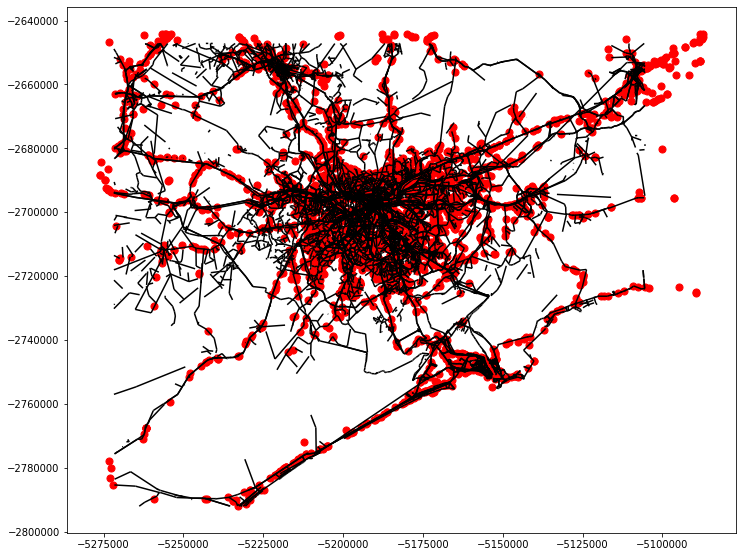

In [31]:
# Load roads as GeoDataFrame
path = DirData/RoadGeod    # 50 m tolerance (? need check)
roads = gpd.read_file(str(path))
# Clean column osm_id
roads['osm_id'] = ( roads['osm_id']
                      .astype(int)    # cut fractional part
                      .astype(str)    # convert to string
                  )
roads = roads.to_crs(WM)
# Plot crashes on roads
fig, ax = plt.subplots(1, figsize=(12, 12))
base = roads.plot(color='black', ax=ax)
crashes.plot(ax=base, marker='o', color='red', markersize=50)
# Display
plt.show()